In [1]:
include("ion13-params.jl");

In [2]:
using LinearAlgebra

In [3]:
using MSSim: FarDetune as FD, Optimizers as Opts
using NLopt
using StaticArrays
using PyPlot

In [4]:
const NSeg = 20
const NIons = 13
const NArgs = 2 * NSeg + NIons * (NSeg + 1)

313

In [5]:
const tgt = FD.AreaTargets{NIons}()
const tgt_scale = 1.5
for i in 1:NIons - 2
    tgt[i, i + 2] = tgt_scale * (((i % 4) in (1, 2)) ? 0.01 : 0.02)
end
for i in 1:8:NIons
    tgt[i, i + 1] = tgt_scale * 0.005
    tgt[i + 2, i + 3] = tgt_scale * 0.005
end
for i in 1:NIons - 1
    for j in i + 1:NIons
        Δ = j - i
        if i == 1 || j == NIons
            w = 0.0
        elseif Δ > 3
            w = 0.002
        elseif Δ > 2
            w = 0.5
        else
            w = 1.0
        end
        FD.setweight!(tgt, w, i, j)
    end
end

In [6]:
const kern = FD.Kernel{NSeg}(2π .* fs, bij, ηs);

In [7]:
const tracker = Opts.NLVarTracker(NArgs)
for i in 1:NSeg
    Opts.set_bound!(tracker, i, 1, 10)
end
for i in NSeg + 1:NSeg + NIons * (NSeg + 1)
    Opts.set_bound!(tracker, i, -1, 1)
end
for i in NSeg + NIons * (NSeg + 1) + 1:2 * NSeg + NIons * (NSeg + 1)
    Opts.set_bound!(tracker, i, 2π * 2, 2π * 2.2)
end

In [8]:
const opt = NLopt.Opt(:LD_LBFGS, NArgs)
NLopt.maxtime!(opt, 10)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))

In [9]:
const total_time_weight = FD.TotalTimeWeight{NSeg}() do t, grad
    if !isempty(grad)
        grad[1] = 1.0
    end
    return t
end

MSSim.FarDetune.TotalTimeWeight{20, var"#2#3"}(var"#2#3"())

In [10]:
function objective(x, grad)
    return total_time_weight(x, grad) do x, grad
        return kern(tgt, x, grad)
    end
end
NLopt.min_objective!(opt, objective)

In [11]:
function opt_one!(opt, tracker, args_buff)
    objval, args, ret = NLopt.optimize!(opt, Opts.init_vars!(tracker, args_buff))
    if getfield(NLopt, ret)::NLopt.Result < 0
        return
    end
    return objval, args
end

opt_one! (generic function with 1 method)

In [12]:
function opt_rep(opt, tracker, n)
    args_buff = Vector{Float64}(undef, ndims(opt))
    best_val = 1
    best_args = nothing
    for i in 1:n
        res = @time opt_one!(opt, tracker, args_buff)
        if res === nothing
            continue
        end
        val, args = res
        if val < best_val
            @show val
            best_val = val
            best_args = copy(args)
        end
    end
    return best_val, best_args
end

opt_rep (generic function with 1 method)

In [13]:
best_val, best_args = @time opt_rep(opt, tracker, 20)

  9.166004 seconds (234.53 k allocations: 9.749 MiB, 2.27% compilation time)
val = 4.4073330467813677e-7
 10.000011 seconds (3 allocations: 80 bytes)
val = 3.976837947419376e-7
 10.000010 seconds
val = 2.427653493651321e-7
 10.000043 seconds
 10.000045 seconds
 10.000016 seconds
  7.827198 seconds
 10.000016 seconds
val = 2.063266721047718e-7
 10.000011 seconds
val = 1.598705566378232e-7
 10.000024 seconds
 10.000031 seconds
  6.771953 seconds
  7.826555 seconds
  8.829433 seconds
 10.000009 seconds
 10.000007 seconds
  7.701173 seconds
 10.000049 seconds
  3.745960 seconds
 10.000010 seconds
181.928135 seconds (362.40 k allocations: 16.206 MiB, 0.15% compilation time)


(1.598705566378232e-7, [6.400031121333885, 1.8884457601129456, 6.82523860160935, 7.471465989151687, 6.300404897894277, 8.24051086212956, 7.530831388158251, 3.083043851878921, 9.368409351882114, 1.7378301898738533  …  13.150090359269118, 13.823007675795091, 13.823007675795091, 13.823007675795091, 13.822970112157236, 13.763804723186697, 13.774707105144586, 13.822963904039767, 13.823007675795091, 13.823007675795091])

In [14]:
best_couplings = Matrix(FD.AreaTargets(kern, best_args))

13×13 Matrix{Float64}:
  0.0          -0.00355163   -0.000424126  …  -5.09181e-6   -7.05605e-7
 -0.00355163    0.0          -5.89815e-8      -3.66804e-7    3.33785e-6
 -0.000424126  -5.89815e-8    0.0             -2.50566e-5    1.26717e-5
  0.000214473   0.0149999     0.00749997      -6.31317e-6    2.96092e-6
 -5.13214e-5   -3.09891e-7    0.0299999       -4.2433e-5     2.31743e-5
 -3.89987e-5   -0.000521816  -1.67525e-7   …  -3.9744e-5     1.60516e-6
  8.29315e-6   -3.85766e-5   -0.000163501     -4.92998e-5    8.5301e-6
 -8.72212e-6   -2.93981e-6   -4.22513e-5      -0.000536066  -6.99524e-5
 -1.5624e-6    -4.1852e-5    -6.64299e-5      -9.41575e-8   -9.89738e-7
 -6.92386e-6    1.98559e-6   -3.04354e-6       0.015         0.000906821
 -2.4588e-6    -6.125e-5      3.14167e-5   …   0.0075       -1.47453e-5
 -5.09181e-6   -3.66804e-7   -2.50566e-5       0.0          -0.0157853
 -7.05605e-7    3.33785e-6    1.26717e-5      -0.0157853     0.0

In [15]:
function plot0(data)
    m = maximum(abs.(data))
    imshow(data, vmax=m, vmin=-m, cmap="bwr")
end

plot0 (generic function with 1 method)

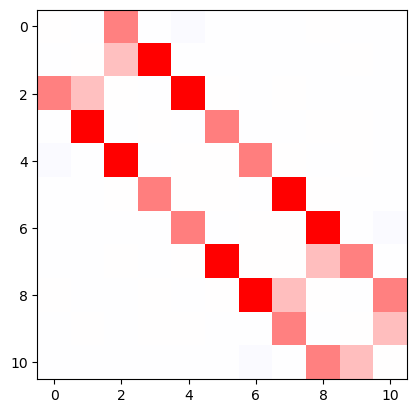

In [16]:
plot0(best_couplings[2:NIons - 1, 2:NIons - 1])
savefig("imgs/qsim_coupling_202510.png")

In [17]:
print(best_args)

[6.400031121333885, 1.8884457601129456, 6.82523860160935, 7.471465989151687, 6.300404897894277, 8.24051086212956, 7.530831388158251, 3.083043851878921, 9.368409351882114, 1.7378301898738533, 1.0067793916357497, 7.610851854917541, 6.641271257036985, 3.3638345933249902, 10.0, 4.485211850330583, 6.280350036846154, 8.38021403043701, 9.50314755402699, 3.899015134894684, -0.20202265035480926, 0.6825023969169008, 0.7883040953679028, -0.5227291497048883, -0.3000095797230182, 0.05611810724692168, 0.689969798252887, 0.5186113194499364, -0.828939262487737, 0.8102000503263467, -0.905582765305095, 0.7515450962047012, -0.6922961559613574, 0.48780771683580726, 0.6554775880372024, -0.5446753246995619, -0.17288196721494042, 0.5690721954530249, -0.7225891578381005, -0.406637308648262, 0.49805541655596275, -0.9841073186969596, -0.9407169408770666, 1.0, 1.0, 1.0, -0.5472572851295086, -0.8175119652304873, -0.973942676812785, -0.813767464916291, -0.8529911003765125, 1.0, -0.9679519926026593, -1.0, -1.0, 0.5

In [18]:
fs

13-element Vector{Float64}:
 2.29049
 2.31223
 2.33447
 2.3566
 2.37964
 2.40187
 2.42345
 2.44437
 2.46325
 2.48068
 2.49643
 2.50981
 2.51649

In [19]:
function couple(ion1, ion2, δ)
    if ion1 == ion2
        return 0.0
    end
    return FD.enclosed_area_modes(1.0, 1.0, 1.0, 1.0, 1.0, δ, 2π .* fs, kern.weights[:, FD.pair_idx(NIons, ion1, ion2)], ())
end

couple (generic function with 1 method)

In [20]:
couple_matrix = [couple(i, j, 2π * 2.2) for i in 1:NIons, j in 1:NIons]

13×13 Matrix{Float64}:
  0.0           0.000574114  -3.3981e-5    …   4.60509e-7   -5.05659e-7
  0.000574114   0.0           0.00119254       2.38066e-8    4.60509e-7
 -3.3981e-5     0.00119254    0.0             -2.61644e-6    7.32209e-7
  2.87253e-5   -0.000187627   0.00181131       1.16217e-6   -5.725e-7
  3.22221e-6    7.61981e-5   -0.000389328      5.64665e-6   -1.07962e-6
  5.98239e-6   -1.45343e-5    0.000149533  …  -3.91176e-6    9.62621e-7
  1.11394e-6    1.40144e-5   -4.73928e-5       1.40144e-5    1.11394e-6
  9.62621e-7   -3.91176e-6    3.39663e-5      -1.45343e-5    5.98239e-6
 -1.07962e-6    5.64665e-6   -1.07321e-5       7.61981e-5    3.22221e-6
 -5.725e-7      1.16217e-6    3.72915e-6      -0.000187627   2.87253e-5
  7.32209e-7   -2.61644e-6    2.92825e-6   …   0.00119254   -3.3981e-5
  4.60509e-7    2.38066e-8   -2.61644e-6       0.0           0.000574114
 -5.05659e-7    4.60509e-7    7.32209e-7       0.000574114   0.0

In [21]:
diag(couple_matrix, 1)[2:end - 1]

10-element Vector{Float64}:
 0.0011925380006325855
 0.001811314904471682
 0.002295785725929463
 0.0025937858141167826
 0.0027162928717463985
 0.0027162928717431663
 0.002593785814120575
 0.0022957857259270405
 0.001811314904472216
 0.0011925380006324344

In [22]:
diag(couple_matrix, 2)[2:end - 1]

9-element Vector{Float64}:
 -0.00018762654358894044
 -0.00038932802714402605
 -0.0005697199738789094
 -0.0006859834667844747
 -0.0007198003362471477
 -0.0006859834667920753
 -0.0005697199738788721
 -0.0003893280271436749
 -0.00018762654358893502

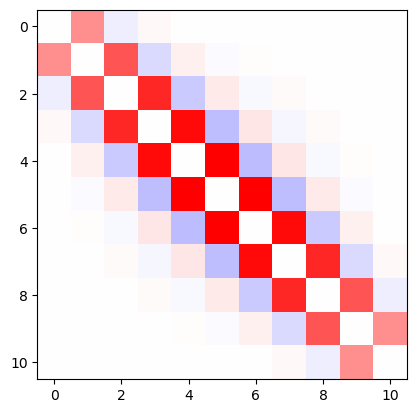

PyObject <matplotlib.image.AxesImage object at 0xfffe74ad2710>

In [23]:
plot0(couple_matrix[2:end - 1, 2:end - 1])

In [24]:
sum(Matrix(tgt)) / 2

0.27

In [25]:
couple_matrix[3, 5], couple_matrix[3, 4]

(-0.00038932802714402605, 0.001811314904471682)